## CNN-BiLSTM-AM SOH Prediction based on Tian et al. (Batteries 2022)

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Dropout, Input, Layer, Permute, Reshape, Multiply, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import os
import time

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("Using GPU")
    # Configure GPU memory growth (optional, prevents TensorFlow from allocating all GPU memory at once)
    gpus = tf.config.list_physical_devices('GPU')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("Using CPU")

# --- Configuration ---
FILE_PATH = '../data/raw_data/' # Assume files are in the current directory or mount Google Drive
BATTERY_NAME = 'B0005' # Choose the battery to process (B0005, B0006, B0018)
NOMINAL_CAPACITY = 2.0
VOLTAGE_HIGH = 3.8
VOLTAGE_LOW = 3.4
SEQUENCE_LENGTH = 10 # Lookback window (adjust as needed, paper doesn't specify)
TRAIN_SPLIT_RATIO = 0.8 # Use 80% for training as per Table 5 example for B0005

# Model Hyperparameters (from Table 3 and text)
FILTER_SIZE = 10
KERNEL_SIZE = 3 # Common choice for Conv1D, adjust if needed
POOL_SIZE = 2   # Common choice
LSTM_UNITS = 160 # As per Table 3 "Number of neurons" - Assuming this is for BiLSTM layer
DROPOUT_RATE = 0.200
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 500 # Reduced from 1000 for faster demo, increase for better results
# Early stopping can prevent overfitting and save time
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=50, # Stop if val_loss doesn't improve for 50 epochs
                                                   restore_best_weights=True)

# --- 1. Data Loading ---
def load_mat_file(filename):
    """Loads battery data from .mat file."""
    print(f"Loading data from {filename}...")
    mat_contents = scipy.io.loadmat(filename)
    # The actual data is nested; adjust key based on file structure inspection
    # Usually it's the filename without extension inside the dict
    key = os.path.splitext(os.path.basename(filename))[0]
    data = mat_contents[key][0, 0]['cycle'][0]
    print(f"Data loaded. Number of cycles: {len(data)}")
    return data


Num GPUs Available:  0
Using CPU


## Feature Extraction (HI) & SOH Calculation 

In [2]:
def extract_hi_soh(battery_data, nominal_capacity, v_high, v_low):
    """Extracts Health Indicator (TIEDVD) and SOH."""
    cycles = []
    soh_values = []
    hi_values = [] # Time Interval of Equal Discharging Voltage Difference (TIEDVD)
    capacities = []

    print("Extracting HI (TIEDVD) and SOH...")
    for i, cycle in enumerate(battery_data):
        cycle_type = cycle['type'][0]
        if cycle_type == 'discharge':
            data = cycle['data'][0, 0]
            capacity = data['Capacity'][0][0]
            voltage = data['Voltage_measured'].flatten()
            time_vec = data['Time'].flatten()

            # --- SOH Calculation ---
            current_soh = (capacity / nominal_capacity)
            capacities.append(capacity)
            soh_values.append(current_soh)
            cycles.append(i + 1) # Use 1-based cycle number

            # --- HI Calculation (TIEDVD) ---
            try:
                # Find indices closest to the target voltages
                idx_high = np.where(voltage <= v_high)[0]
                idx_low = np.where(voltage <= v_low)[0]

                if len(idx_high) > 0 and len(idx_low) > 0:
                     # Use interpolation for better accuracy
                     time_high = np.interp(v_high, voltage[idx_high[0]-1:idx_high[0]+1][::-1], time_vec[idx_high[0]-1:idx_high[0]+1][::-1])
                     time_low = np.interp(v_low, voltage[idx_low[0]-1:idx_low[0]+1][::-1], time_vec[idx_low[0]-1:idx_low[0]+1][::-1])

                     tiedvd = time_low - time_high
                     if tiedvd < 0: # Should not happen in normal discharge
                        # print(f"Warning: Negative TIEDVD ({tiedvd:.2f}) at cycle {i+1}. Using fallback.")
                        # Fallback: Find nearest indices if interpolation fails or gives weird results
                        time_at_vh = time_vec[np.abs(voltage - v_high).argmin()]
                        time_at_vl = time_vec[np.abs(voltage - v_low).argmin()]
                        tiedvd = time_at_vl - time_at_vh
                        if tiedvd < 0: # If still negative, something's wrong, skip or use 0
                           tiedvd = 0
                else:
                    # If voltages are not crossed, TIEDVD is not well-defined for this cycle
                    # print(f"Warning: Voltage range [{v_low}V, {v_high}V] not found in cycle {i+1}. Setting TIEDVD to 0.")
                    tiedvd = 0 # Or handle differently (e.g., extrapolate, use previous value)

                hi_values.append(tiedvd)

            except Exception as e:
                print(f"Error calculating TIEDVD for cycle {i+1}: {e}. Setting TIEDVD to 0.")
                hi_values.append(0) # Append 0 or NaN if error occurs

    print(f"Extraction complete. Found {len(soh_values)} discharge cycles.")
    # Filter out cycles where HI calculation might have failed (if appended NaN)
    # For simplicity here, we assume 0 is okay if calculation failed.
    return np.array(cycles), np.array(soh_values), np.array(hi_values), np.array(capacities)

## 4. Preprocessing

In [3]:
def preprocess_data(hi_data, soh_data, sequence_length):
    """Normalize data and create sequences."""
    print("Preprocessing data...")
    # Normalize HI (TIEDVD) and SOH
    scaler_hi = MinMaxScaler(feature_range=(0, 1))
    scaler_soh = MinMaxScaler(feature_range=(0, 1))

    # Reshape for scaler (expects 2D array)
    hi_scaled = scaler_hi.fit_transform(hi_data.reshape(-1, 1)).flatten()
    soh_scaled = scaler_soh.fit_transform(soh_data.reshape(-1, 1)).flatten()

    # Create sequences
    X, y = [], []
    for i in range(len(hi_scaled) - sequence_length):
        X.append(hi_scaled[i:(i + sequence_length)])
        y.append(soh_scaled[i + sequence_length]) # Predict SOH of the next cycle

    X = np.array(X)
    y = np.array(y)

    # Reshape X for CNN/LSTM input: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    print(f"Data shaped into sequences. X shape: {X.shape}, y shape: {y.shape}")
    return X, y, scaler_hi, scaler_soh


## Custom Attention Layer (Based on Equations 8-10) 

In [4]:
class SimpleAttention(Layer):
    def __init__(self, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, time_steps, features)
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_context_vector', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        super(SimpleAttention, self).build(input_shape)

    def call(self, x):
        # x shape: (batch_size, time_steps, features)

        # Equation 8: ut = tanh(Ww*ht + bw) -> ht is input x here
        # Apply Dense layer logic: Wx + b
        # Need to apply W and b to each timestep. Use tf.tensordot for batch matrix multiplication
        # Or simply use a TimeDistributed Dense layer internally? No, let's do it manually.
        # Wx = einsum('btd,df->btf', x, self.W) -> batch, time, features
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b) # uit shape: (batch_size, time_steps, features)

        # Equation 9: at = softmax(ut^T * uw) -> uw is self.u
        # Need dot product between uit and u for each timestep
        # alpha_t = einsum('btf, fi -> bti', uit, self.u) -> gives score per timestep
        # alpha_t shape: (batch_size, time_steps, 1)
        alpha_t_scores = tf.tensordot(uit, self.u, axes=1) # alpha_t shape: (batch_size, time_steps, 1)

        # Apply softmax across the time dimension (axis=1)
        alpha_t_weights = tf.nn.softmax(alpha_t_scores, axis=1) # alpha_t shape: (batch_size, time_steps, 1)

        # Equation 10: z = sum(at * ht) -> ht is input x
        # Weighted sum: Multiply weights with input sequence and sum over time
        # context_vector = einsum('bti, btf -> bfi', alpha_t_weights, x) -> error in dimensions
        # Need to multiply element-wise and sum: sum(weights * input, axis=1)
        # weights shape: (b, t, 1), input shape: (b, t, f) -> should broadcast
        context_vector = tf.reduce_sum(alpha_t_weights * x, axis=1) # context_vector shape: (batch_size, features)

        return context_vector

    def compute_output_shape(self, input_shape):
        # Output shape is (batch_size, features)
        return (input_shape[0], input_shape[-1])

## 5. Model Building

In [5]:
def build_cnn_bilstm_am(seq_length, n_features, lstm_units, filter_size, kernel_size, pool_size, dropout_rate):
    """Builds the CNN-BiLSTM-AM model."""
    print("Building CNN-BiLSTM-AM model...")
    input_layer = Input(shape=(seq_length, n_features))

    # CNN Layer
    x = Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=pool_size, padding='same')(x)
    x = Dropout(dropout_rate)(x)
    # Optional: Add more CNN layers if needed
    # x = Conv1D(filters=filter_size*2, kernel_size=kernel_size, activation='relu', padding='same')(x)
    # x = MaxPooling1D(pool_size=pool_size, padding='same')(x)
    # x = Dropout(dropout_rate)(x)

    # BiLSTM Layer
    # Need return_sequences=True for the Attention layer
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    # Optional: Stack BiLSTM layers
    # x = Bidirectional(LSTM(lstm_units // 2, return_sequences=True))(x)
    # x = Dropout(dropout_rate)(x)

    # Attention Mechanism Layer
    x = SimpleAttention()(x) # Output shape: (batch_size, lstm_units * 2) because BiLSTM doubles the units

    # Output Layer
    output_layer = Dense(1, activation='linear')(x) # Linear activation for regression

    model = Model(inputs=input_layer, outputs=output_layer)
    print("Model built successfully.")
    return model

## 6. Training & 7. Evaluation

In [6]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, scaler_soh, batch_size, epochs, learning_rate, callbacks=[]):
    """Compile, train, and evaluate the model."""
    # Compile
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) # Use Keras MAE
    model.summary()

    # Train
    print("Starting training...")
    start_time = time.time()
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.1, # Use 10% of training data for validation
                        callbacks=callbacks,
                        verbose=1)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training finished. Time taken: {training_time:.2f} seconds")

    # Evaluate
    print("Evaluating model on test set...")
    y_pred_scaled = model.predict(X_test)

    # Inverse transform to get actual SOH values
    y_pred = scaler_soh.inverse_transform(y_pred_scaled)
    y_true = scaler_soh.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # MAPE calculation (handle potential zero values in y_true)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100 # Avoid division by zero

    print(f"Evaluation Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.3f}%")

    return history, y_true, y_pred, rmse, mae, mape, training_time

## 8. Visualization

In [7]:
def plot_results(history, y_true, y_pred, cycles_test, battery_name):
    """Plots training history and prediction results."""
    plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style

    # Plot training & validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{battery_name} - Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plot training & validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{battery_name} - Model MAE')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Actual vs Predicted SOH
    plt.figure(figsize=(10, 6))
    plt.plot(cycles_test, y_true, label='Actual SOH', marker='o', linestyle='-', markersize=4)
    plt.plot(cycles_test, y_pred, label='Predicted SOH', marker='x', linestyle='--', markersize=4)
    plt.title(f'SOH Prediction for {battery_name} (Test Set)')
    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (SOH)')
    plt.legend()
    plt.grid(True)
    plt.ylim(min(np.min(y_true), np.min(y_pred)) - 0.05, max(np.max(y_true), np.max(y_pred)) + 0.05) # Adjust y-axis limits
    plt.show()

def plot_hi_soh_cap(cycles, soh, hi, capacity, battery_name):
    """ Plots HI, SOH, and Capacity curves. """
    fig, ax1 = plt.subplots(figsize=(10, 6))
    color = 'tab:red'
    ax1.set_xlabel('Cycle Number')
    ax1.set_ylabel('SOH', color=color)
    ax1.plot(cycles, soh, color=color, label='SOH', marker='.', linestyle='-')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, axis='y', linestyle=':', color=color, alpha=0.6)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('HI (TIEDVD - seconds)', color=color)
    ax2.plot(cycles, hi, color=color, label='HI (TIEDVD)', marker='x', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid(True, axis='y', linestyle=':', color=color, alpha=0.6)

    # Optional: Add Capacity on a third axis if needed, might get cluttered
    # ax3 = ax1.twinx()
    # fig.subplots_adjust(right=0.75) # Make room for third axis
    # ax3.spines['right'].set_position(('outward', 60))
    # color = 'tab:green'
    # ax3.set_ylabel('Capacity (Ah)', color=color)
    # ax3.plot(cycles, capacity, color=color, label='Capacity', marker='s', linestyle=':')
    # ax3.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'SOH and HI (TIEDVD) vs. Cycle for {battery_name}')
    # Add legends manually if using multiple axes like this
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower left')
    plt.grid(True)
    plt.show()

## Main Execution

Loading data from ../data/raw_data/B0005.mat...
Data loaded. Number of cycles: 616
Extracting HI (TIEDVD) and SOH...
Extraction complete. Found 168 discharge cycles.


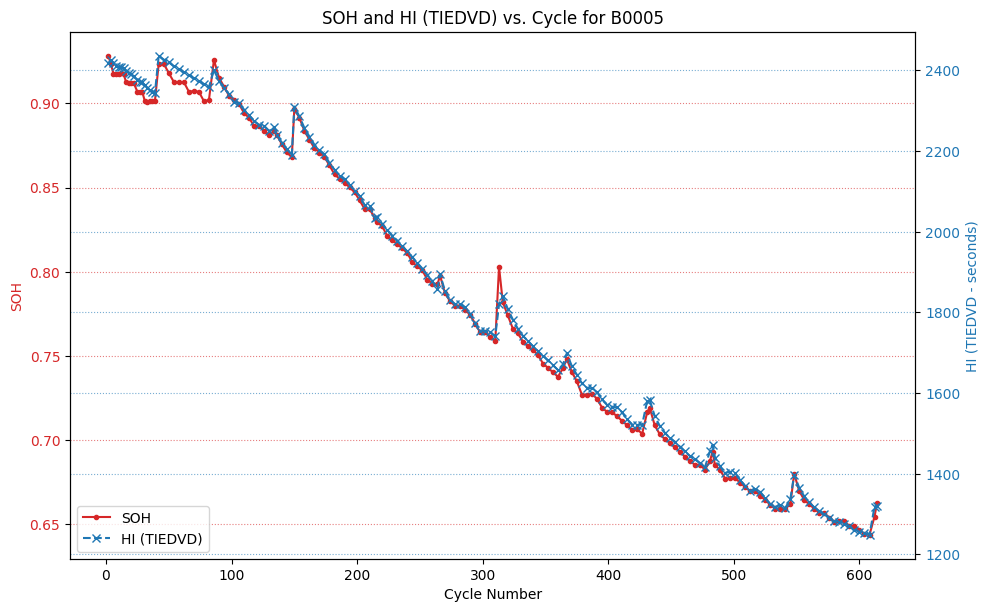

Preprocessing data...
Data shaped into sequences. X shape: (158, 10, 1), y shape: (158,)
Data split:
  X_train shape: (126, 10, 1), y_train shape: (126,)
  X_test shape:  (32, 10, 1), y_test shape: (32,)
  Test cycles range from 493 to 614
Building CNN-BiLSTM-AM model...
Model built successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 10)         │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 5, 320)         │       218,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 320)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_attention                │ (None, 320)            │       103,040 │
│ (SimpleAttention)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,281 (1.23 MB)

 Trainable params: 322,281 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4181 - mae: 0.5943 - val_loss: 6.5218e-04 - val_mae: 0.0220
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0633 - mae: 0.1986 - val_loss: 0.0497 - val_mae: 0.2224
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0427 - mae: 0.1836 - val_loss: 0.0186 - val_mae: 0.1355
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - mae: 0.0785 - val_loss: 0.0134 - val_mae: 0.1147
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - mae: 0.0823 - val_loss: 0.0220 - val_mae: 0.1475
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - mae: 0.0956 - val_loss: 0.0160 - val_mae: 0.1258
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0110 - mae: 0.0819 - val_loss: 0.0153 - val_mae: 0.1226
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0126 - mae: 0.0944 - val_loss: 0.0109 - val_mae: 0.1034
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - los

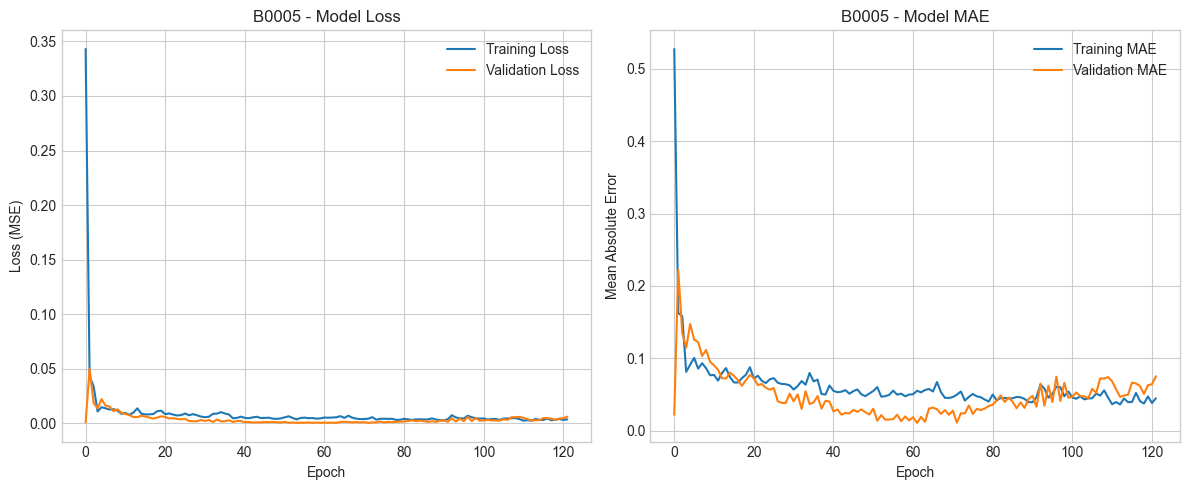

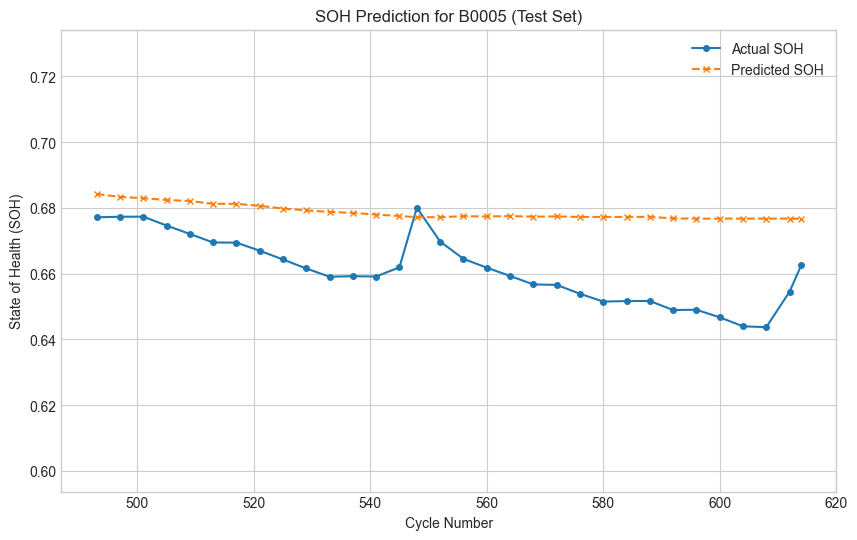


--- Summary ---
Battery:        B0005
Training Time:  10.99 seconds
Sequence Length:10
Epochs Run:     122
Test RMSE:      0.0195
Test MAE:       0.0177
Test MAPE:      2.699%
----------------


In [8]:
if __name__ == "__main__":
    mat_file = os.path.join(FILE_PATH, f'{BATTERY_NAME}.mat')

    # 1. Load Data
    battery_data = load_mat_file(mat_file)

    # 2. & 3. Extract HI & SOH
    cycles, soh_values, hi_values, capacity_values = extract_hi_soh(battery_data, NOMINAL_CAPACITY, VOLTAGE_HIGH, VOLTAGE_LOW)

    # Plot extracted features
    plot_hi_soh_cap(cycles, soh_values, hi_values, capacity_values, BATTERY_NAME)

    # 4. Preprocess Data
    X, y, scaler_hi, scaler_soh = preprocess_data(hi_values, soh_values, SEQUENCE_LENGTH)

    # Split data (chronologically)
    split_index = int(len(X) * TRAIN_SPLIT_RATIO)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    cycles_test = cycles[split_index + SEQUENCE_LENGTH:] # Align cycle numbers with test predictions

    print(f"Data split:")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"  X_test shape:  {X_test.shape}, y_test shape: {y_test.shape}")
    print(f"  Test cycles range from {cycles_test[0]} to {cycles_test[-1]}")

    # 5. Build Model
    model = build_cnn_bilstm_am(
        seq_length=SEQUENCE_LENGTH,
        n_features=1, # Only using TIEDVD
        lstm_units=LSTM_UNITS,
        filter_size=FILTER_SIZE,
        kernel_size=KERNEL_SIZE,
        pool_size=POOL_SIZE,
        dropout_rate=DROPOUT_RATE
    )

    # 6. & 7. Train and Evaluate
    history, y_true, y_pred, rmse, mae, mape, training_time = train_and_evaluate(
        model, X_train, y_train, X_test, y_test, scaler_soh,
        BATCH_SIZE, EPOCHS, LEARNING_RATE, callbacks=[early_stopping]
    )

    # 8. Visualize
    plot_results(history, y_true, y_pred, cycles_test, BATTERY_NAME)

    print("\n--- Summary ---")
    print(f"Battery:        {BATTERY_NAME}")
    print(f"Training Time:  {training_time:.2f} seconds")
    print(f"Sequence Length:{SEQUENCE_LENGTH}")
    print(f"Epochs Run:     {len(history.history['loss'])}") # Actual epochs run if early stopping triggered
    print(f"Test RMSE:      {rmse:.4f}")
    print(f"Test MAE:       {mae:.4f}")
    print(f"Test MAPE:      {mape:.3f}%")
    print("----------------")

## Single Cell (TEST FOR B0018)

Num GPUs Available:  0
Using CPU
Loading data from ../data/raw_data/B0018.mat...
Data loaded. Number of cycles: 319
Extracting HI (TIEDVD) and SOH...
Extraction complete. Found 132 discharge cycles.


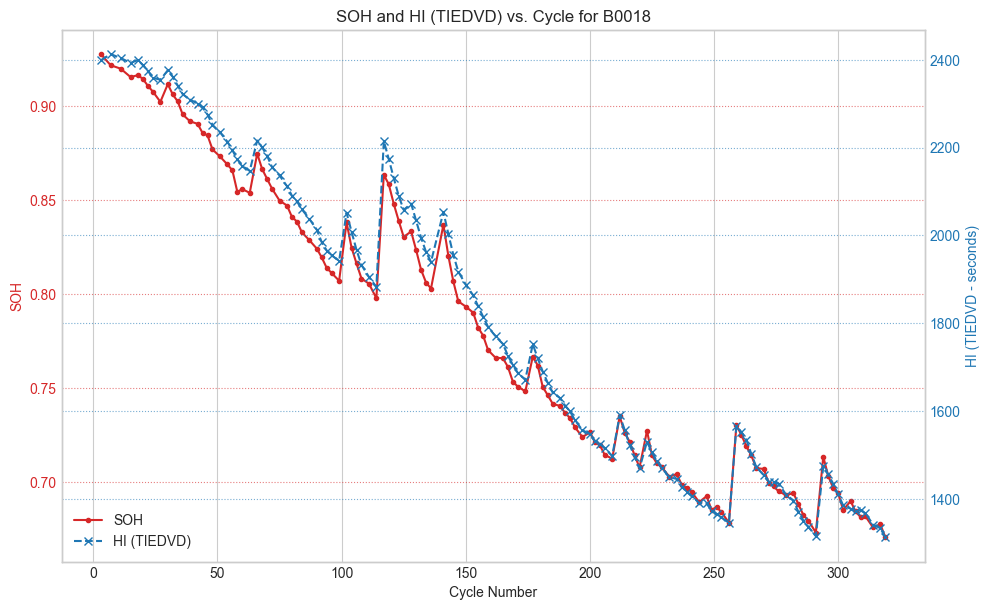

Preprocessing data...
Data shaped into sequences. X shape: (117, 15, 1), y shape: (117,)
Data split:
  X_train shape: (93, 15, 1), y_train shape: (93,)
  X_test shape:  (24, 15, 1), y_test shape: (24,)
  Test cycles range from 265 to 319
Building CNN-BiLSTM-AM model...
Model built successfully.


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 15, 20)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 8, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 8, 320)         │       231,680 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 8, 320)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_attention_16             │ (None, 320)            │       103,040 │
│ (SimpleAttention)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,121 (1.28 MB)

 Trainable params: 335,121 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1584 - mae: 0.3468 - val_loss: 0.0107 - val_mae: 0.0964
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - mae: 0.1088 - val_loss: 0.0207 - val_mae: 0.1256
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0158 - mae: 0.1090 - val_loss: 0.0078 - val_mae: 0.0868
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0130 - mae: 0.0877 - val_loss: 0.0069 - val_mae: 0.0820
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111 - mae: 0.0841 - val_loss: 0.0099 - val_mae: 0.0952
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0087 - mae: 0.0782 - val_loss: 0.0110 - val_mae: 0.0988
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0093 - mae: 0.0845 - val_loss: 0.0074 - val_mae: 0.0848
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - mae: 0.0679 - val_loss: 0.0065 - val_mae: 0.0787
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

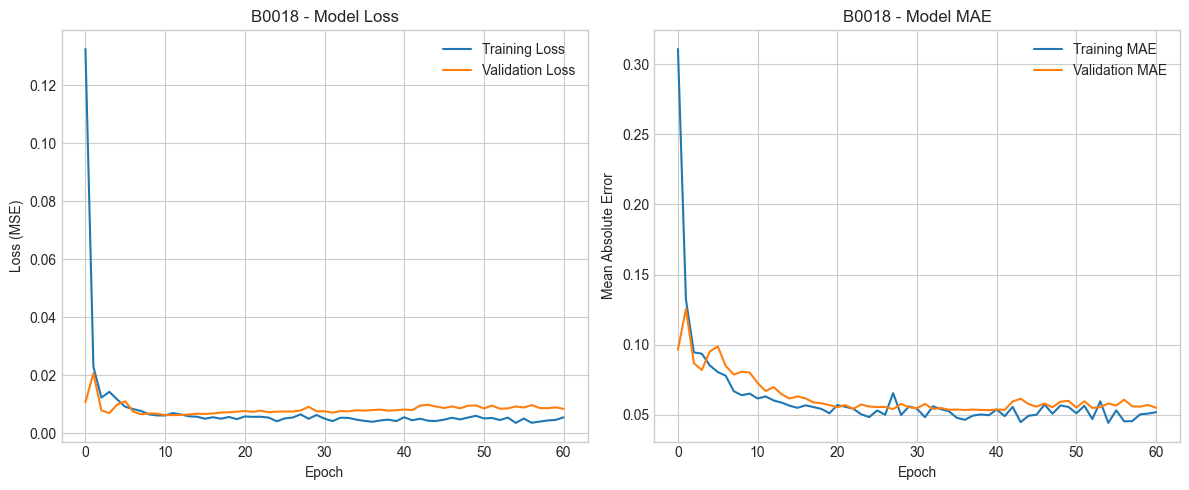

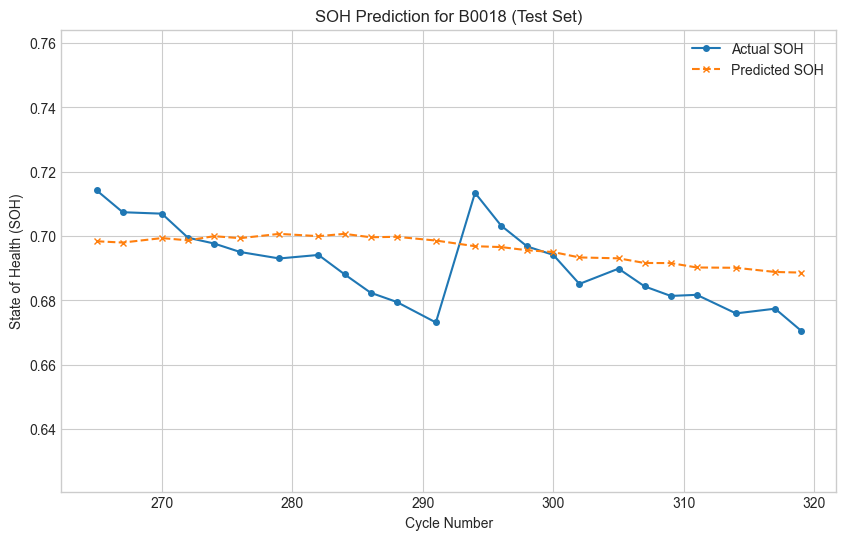


--- Summary ---
Battery:        B0018
Training Time:  6.84 seconds
Sequence Length:15
Epochs Run:     61
Test RMSE:      0.0118
Test MAE:       0.0098
Test MAPE:      1.428%
----------------


In [32]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Dropout, Input, Layer, Permute, Reshape, Multiply, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import os
import time

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("Using GPU")
    # Configure GPU memory growth (optional, prevents TensorFlow from allocating all GPU memory at once)
    gpus = tf.config.list_physical_devices('GPU')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("Using CPU")

# --- Configuration ---
FILE_PATH = '../data/raw_data/' # Assume files are in the current directory or mount Google Drive
BATTERY_NAME = 'B0018' # Choose the battery to process (B0005, B0006, B0018)
NOMINAL_CAPACITY = 2.0
VOLTAGE_HIGH = 3.8
VOLTAGE_LOW = 3.4
SEQUENCE_LENGTH = 15 # Lookback window (adjust as needed, paper doesn't specify)
TRAIN_SPLIT_RATIO = 0.8 # Use 80% for training as per Table 5 example for B0005

# Model Hyperparameters (from Table 3 and text)
FILTER_SIZE = 20
KERNEL_SIZE = 3 # Common choice for Conv1D, adjust if needed
POOL_SIZE = 2   # Common choice
LSTM_UNITS = 160 # As per Table 3 "Number of neurons" - Assuming this is for BiLSTM layer
DROPOUT_RATE = 0.200
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 500 # Reduced from 1000 for faster demo, increase for better results
# Early stopping can prevent overfitting and save time
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=50, # Stop if val_loss doesn't improve for 50 epochs
                                                   restore_best_weights=True)

# --- 1. Data Loading ---
def load_mat_file(filename):
    """Loads battery data from .mat file."""
    print(f"Loading data from {filename}...")
    mat_contents = scipy.io.loadmat(filename)
    # The actual data is nested; adjust key based on file structure inspection
    # Usually it's the filename without extension inside the dict
    key = os.path.splitext(os.path.basename(filename))[0]
    data = mat_contents[key][0, 0]['cycle'][0]
    print(f"Data loaded. Number of cycles: {len(data)}")
    return data


# --- 2. Feature Extraction (HI) & 3. SOH Calculation ---
def extract_hi_soh(battery_data, nominal_capacity, v_high, v_low):
    """Extracts Health Indicator (TIEDVD) and SOH."""
    cycles = []
    soh_values = []
    hi_values = [] # Time Interval of Equal Discharging Voltage Difference (TIEDVD)
    capacities = []

    print("Extracting HI (TIEDVD) and SOH...")
    for i, cycle in enumerate(battery_data):
        cycle_type = cycle['type'][0]
        if cycle_type == 'discharge':
            data = cycle['data'][0, 0]
            capacity = data['Capacity'][0][0]
            voltage = data['Voltage_measured'].flatten()
            time_vec = data['Time'].flatten()

            # --- SOH Calculation ---
            current_soh = (capacity / nominal_capacity)
            capacities.append(capacity)
            soh_values.append(current_soh)
            cycles.append(i + 1) # Use 1-based cycle number

            # --- HI Calculation (TIEDVD) ---
            try:
                # Find indices closest to the target voltages
                idx_high = np.where(voltage <= v_high)[0]
                idx_low = np.where(voltage <= v_low)[0]

                if len(idx_high) > 0 and len(idx_low) > 0:
                     # Use interpolation for better accuracy
                     time_high = np.interp(v_high, voltage[idx_high[0]-1:idx_high[0]+1][::-1], time_vec[idx_high[0]-1:idx_high[0]+1][::-1])
                     time_low = np.interp(v_low, voltage[idx_low[0]-1:idx_low[0]+1][::-1], time_vec[idx_low[0]-1:idx_low[0]+1][::-1])

                     tiedvd = time_low - time_high
                     if tiedvd < 0: # Should not happen in normal discharge
                        # print(f"Warning: Negative TIEDVD ({tiedvd:.2f}) at cycle {i+1}. Using fallback.")
                        # Fallback: Find nearest indices if interpolation fails or gives weird results
                        time_at_vh = time_vec[np.abs(voltage - v_high).argmin()]
                        time_at_vl = time_vec[np.abs(voltage - v_low).argmin()]
                        tiedvd = time_at_vl - time_at_vh
                        if tiedvd < 0: # If still negative, something's wrong, skip or use 0
                           tiedvd = 0
                else:
                    # If voltages are not crossed, TIEDVD is not well-defined for this cycle
                    # print(f"Warning: Voltage range [{v_low}V, {v_high}V] not found in cycle {i+1}. Setting TIEDVD to 0.")
                    tiedvd = 0 # Or handle differently (e.g., extrapolate, use previous value)

                hi_values.append(tiedvd)

            except Exception as e:
                print(f"Error calculating TIEDVD for cycle {i+1}: {e}. Setting TIEDVD to 0.")
                hi_values.append(0) # Append 0 or NaN if error occurs

    print(f"Extraction complete. Found {len(soh_values)} discharge cycles.")
    # Filter out cycles where HI calculation might have failed (if appended NaN)
    # For simplicity here, we assume 0 is okay if calculation failed.
    return np.array(cycles), np.array(soh_values), np.array(hi_values), np.array(capacities)

# --- 4. Preprocessing ---
def preprocess_data(hi_data, soh_data, sequence_length):
    """Normalize data and create sequences."""
    print("Preprocessing data...")
    # Normalize HI (TIEDVD) and SOH
    scaler_hi = MinMaxScaler(feature_range=(0, 1))
    scaler_soh = MinMaxScaler(feature_range=(0, 1))

    # Reshape for scaler (expects 2D array)
    hi_scaled = scaler_hi.fit_transform(hi_data.reshape(-1, 1)).flatten()
    soh_scaled = scaler_soh.fit_transform(soh_data.reshape(-1, 1)).flatten()

    # Create sequences
    X, y = [], []
    for i in range(len(hi_scaled) - sequence_length):
        X.append(hi_scaled[i:(i + sequence_length)])
        y.append(soh_scaled[i + sequence_length]) # Predict SOH of the next cycle

    X = np.array(X)
    y = np.array(y)

    # Reshape X for CNN/LSTM input: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    print(f"Data shaped into sequences. X shape: {X.shape}, y shape: {y.shape}")
    return X, y, scaler_hi, scaler_soh

# --- Custom Attention Layer (Based on Equations 8-10) ---
class SimpleAttention(Layer):
    def __init__(self, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, time_steps, features)
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_context_vector', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        super(SimpleAttention, self).build(input_shape)

    def call(self, x):
        # x shape: (batch_size, time_steps, features)

        # Equation 8: ut = tanh(Ww*ht + bw) -> ht is input x here
        # Apply Dense layer logic: Wx + b
        # Need to apply W and b to each timestep. Use tf.tensordot for batch matrix multiplication
        # Or simply use a TimeDistributed Dense layer internally? No, let's do it manually.
        # Wx = einsum('btd,df->btf', x, self.W) -> batch, time, features
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b) # uit shape: (batch_size, time_steps, features)

        # Equation 9: at = softmax(ut^T * uw) -> uw is self.u
        # Need dot product between uit and u for each timestep
        # alpha_t = einsum('btf, fi -> bti', uit, self.u) -> gives score per timestep
        # alpha_t shape: (batch_size, time_steps, 1)
        alpha_t_scores = tf.tensordot(uit, self.u, axes=1) # alpha_t shape: (batch_size, time_steps, 1)

        # Apply softmax across the time dimension (axis=1)
        alpha_t_weights = tf.nn.softmax(alpha_t_scores, axis=1) # alpha_t shape: (batch_size, time_steps, 1)

        # Equation 10: z = sum(at * ht) -> ht is input x
        # Weighted sum: Multiply weights with input sequence and sum over time
        # context_vector = einsum('bti, btf -> bfi', alpha_t_weights, x) -> error in dimensions
        # Need to multiply element-wise and sum: sum(weights * input, axis=1)
        # weights shape: (b, t, 1), input shape: (b, t, f) -> should broadcast
        context_vector = tf.reduce_sum(alpha_t_weights * x, axis=1) # context_vector shape: (batch_size, features)

        return context_vector

    def compute_output_shape(self, input_shape):
        # Output shape is (batch_size, features)
        return (input_shape[0], input_shape[-1])

# --- 5. Model Building ---
def build_cnn_bilstm_am(seq_length, n_features, lstm_units, filter_size, kernel_size, pool_size, dropout_rate):
    """Builds the CNN-BiLSTM-AM model."""
    print("Building CNN-BiLSTM-AM model...")
    input_layer = Input(shape=(seq_length, n_features))

    # CNN Layer
    x = Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=pool_size, padding='same')(x)
    x = Dropout(dropout_rate)(x)
    # Optional: Add more CNN layers if needed
    # x = Conv1D(filters=filter_size*2, kernel_size=kernel_size, activation='relu', padding='same')(x)
    # x = MaxPooling1D(pool_size=pool_size, padding='same')(x)
    # x = Dropout(dropout_rate)(x)

    # BiLSTM Layer
    # Need return_sequences=True for the Attention layer
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    # Optional: Stack BiLSTM layers
    # x = Bidirectional(LSTM(lstm_units // 2, return_sequences=True))(x)
    # x = Dropout(dropout_rate)(x)

    # Attention Mechanism Layer
    x = SimpleAttention()(x) # Output shape: (batch_size, lstm_units * 2) because BiLSTM doubles the units

    # Output Layer
    output_layer = Dense(1, activation='linear')(x) # Linear activation for regression

    model = Model(inputs=input_layer, outputs=output_layer)
    print("Model built successfully.")
    return model

# --- 6. Training & 7. Evaluation ---
def train_and_evaluate(model, X_train, y_train, X_test, y_test, scaler_soh, batch_size, epochs, learning_rate, callbacks=[]):
    """Compile, train, and evaluate the model."""
    # Compile
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) # Use Keras MAE
    model.summary()

    # Train
    print("Starting training...")
    start_time = time.time()
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.1, # Use 10% of training data for validation
                        callbacks=callbacks,
                        verbose=1)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training finished. Time taken: {training_time:.2f} seconds")

    # Evaluate
    print("Evaluating model on test set...")
    y_pred_scaled = model.predict(X_test)

    # Inverse transform to get actual SOH values
    y_pred = scaler_soh.inverse_transform(y_pred_scaled)
    y_true = scaler_soh.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # MAPE calculation (handle potential zero values in y_true)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100 # Avoid division by zero

    print(f"Evaluation Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.3f}%")

    return history, y_true, y_pred, rmse, mae, mape, training_time

# --- 8. Visualization ---
def plot_results(history, y_true, y_pred, cycles_test, battery_name):
    """Plots training history and prediction results."""
    plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style

    # Plot training & validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{battery_name} - Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plot training & validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{battery_name} - Model MAE')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Actual vs Predicted SOH
    plt.figure(figsize=(10, 6))
    plt.plot(cycles_test, y_true, label='Actual SOH', marker='o', linestyle='-', markersize=4)
    plt.plot(cycles_test, y_pred, label='Predicted SOH', marker='x', linestyle='--', markersize=4)
    plt.title(f'SOH Prediction for {battery_name} (Test Set)')
    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (SOH)')
    plt.legend()
    plt.grid(True)
    plt.ylim(min(np.min(y_true), np.min(y_pred)) - 0.05, max(np.max(y_true), np.max(y_pred)) + 0.05) # Adjust y-axis limits
    plt.show()

def plot_hi_soh_cap(cycles, soh, hi, capacity, battery_name):
    """ Plots HI, SOH, and Capacity curves. """
    fig, ax1 = plt.subplots(figsize=(10, 6))
    color = 'tab:red'
    ax1.set_xlabel('Cycle Number')
    ax1.set_ylabel('SOH', color=color)
    ax1.plot(cycles, soh, color=color, label='SOH', marker='.', linestyle='-')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, axis='y', linestyle=':', color=color, alpha=0.6)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('HI (TIEDVD - seconds)', color=color)
    ax2.plot(cycles, hi, color=color, label='HI (TIEDVD)', marker='x', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid(True, axis='y', linestyle=':', color=color, alpha=0.6)

    # Optional: Add Capacity on a third axis if needed, might get cluttered
    # ax3 = ax1.twinx()
    # fig.subplots_adjust(right=0.75) # Make room for third axis
    # ax3.spines['right'].set_position(('outward', 60))
    # color = 'tab:green'
    # ax3.set_ylabel('Capacity (Ah)', color=color)
    # ax3.plot(cycles, capacity, color=color, label='Capacity', marker='s', linestyle=':')
    # ax3.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'SOH and HI (TIEDVD) vs. Cycle for {battery_name}')
    # Add legends manually if using multiple axes like this
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower left')
    plt.grid(True)
    plt.show()
    
# --- Main Execution ---
if __name__ == "__main__":
    mat_file = os.path.join(FILE_PATH, f'{BATTERY_NAME}.mat')

    # 1. Load Data
    battery_data = load_mat_file(mat_file)

    # 2. & 3. Extract HI & SOH
    cycles, soh_values, hi_values, capacity_values = extract_hi_soh(battery_data, NOMINAL_CAPACITY, VOLTAGE_HIGH, VOLTAGE_LOW)

    # Plot extracted features
    plot_hi_soh_cap(cycles, soh_values, hi_values, capacity_values, BATTERY_NAME)

    # 4. Preprocess Data
    X, y, scaler_hi, scaler_soh = preprocess_data(hi_values, soh_values, SEQUENCE_LENGTH)

    # Split data (chronologically)
    split_index = int(len(X) * TRAIN_SPLIT_RATIO)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    cycles_test = cycles[split_index + SEQUENCE_LENGTH:] # Align cycle numbers with test predictions

    print(f"Data split:")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"  X_test shape:  {X_test.shape}, y_test shape: {y_test.shape}")
    print(f"  Test cycles range from {cycles_test[0]} to {cycles_test[-1]}")

    # 5. Build Model
    model = build_cnn_bilstm_am(
        seq_length=SEQUENCE_LENGTH,
        n_features=1, # Only using TIEDVD
        lstm_units=LSTM_UNITS,
        filter_size=FILTER_SIZE,
        kernel_size=KERNEL_SIZE,
        pool_size=POOL_SIZE,
        dropout_rate=DROPOUT_RATE
    )

    # 6. & 7. Train and Evaluate
    history, y_true, y_pred, rmse, mae, mape, training_time = train_and_evaluate(
        model, X_train, y_train, X_test, y_test, scaler_soh,
        BATCH_SIZE, EPOCHS, LEARNING_RATE, callbacks=[early_stopping]
    )

    # 8. Visualize
    plot_results(history, y_true, y_pred, cycles_test, BATTERY_NAME)

    print("\n--- Summary ---")
    print(f"Battery:        {BATTERY_NAME}")
    print(f"Training Time:  {training_time:.2f} seconds")
    print(f"Sequence Length:{SEQUENCE_LENGTH}")
    print(f"Epochs Run:     {len(history.history['loss'])}") # Actual epochs run if early stopping triggered
    print(f"Test RMSE:      {rmse:.4f}")
    print(f"Test MAE:       {mae:.4f}")
    print(f"Test MAPE:      {mape:.3f}%")
    print("----------------")

## Hyperparameter Tuning & SP Analysis

TensorFlow Version: 2.19.0
Using CPU
--- Starting Hyperparameter Tuning ---
Total experiments to run: 216

=== Processing Battery: B0005 ===
Loading data from ../data/raw_data/B0005.mat...
Data loaded. Found 616 total operations.
Extracting HI (TIEDVD) and SOH from discharge cycles...
Extraction complete. Found 168 valid discharge cycles.

--- Testing SP = 70% ---

Running Experiment 1/216: B0005_SP70_Seq5_K3_P2_F10_L80
Created sequences. X shape: (163, 5, 1), y shape: (163,)
  Train shape: (114, 5, 1), Test shape: (49, 5, 1)

Running Experiment 2/216: B0005_SP70_Seq5_K3_P2_F10_L160
Created sequences. X shape: (163, 5, 1), y shape: (163,)
  Train shape: (114, 5, 1), Test shape: (49, 5, 1)

Running Experiment 3/216: B0005_SP70_Seq5_K3_P2_F20_L80
Created sequences. X shape: (163, 5, 1), y shape: (163,)
  Train shape: (114, 5, 1), Test shape: (49, 5, 1)

Running Experiment 4/216: B0005_SP70_Seq5_K3_P2_F20_L160
Created sequences. X shape: (163, 5, 1), y shape: (163,)
  Train shape: (114, 5

/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_55605/563107794.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['config_label'] = df_plot.apply(lambda row: f"Seq{int(row['seq_len'])}_K{int(row['kernel'])}_P{int(row['pool'])}_F{int(row['filter'])}_L{int(row['lstm'])}", axis=1)


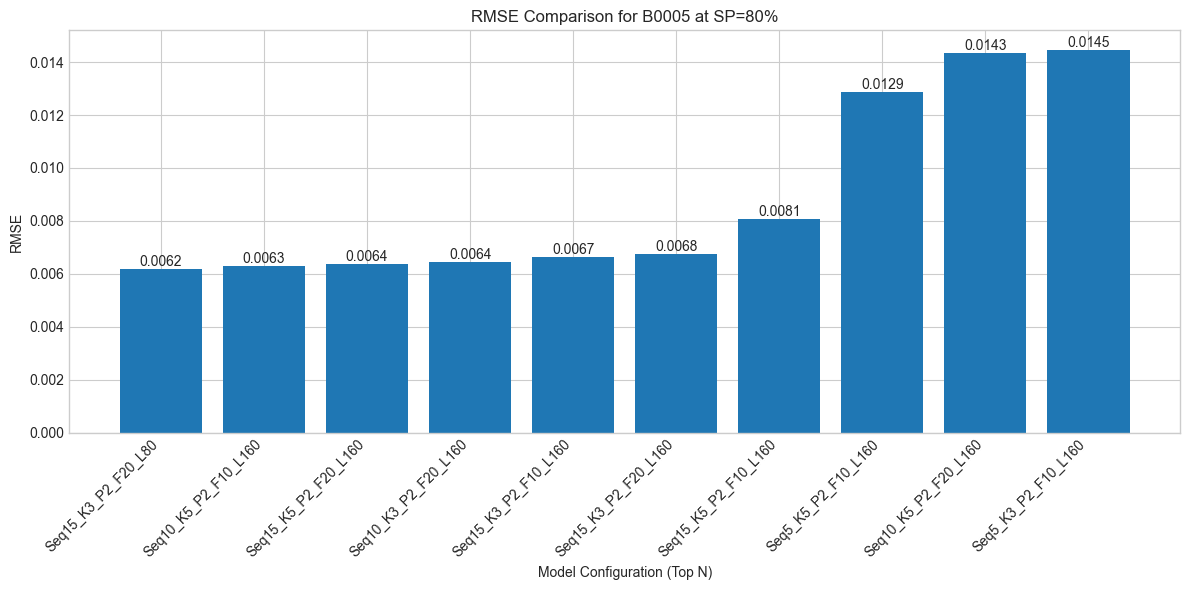

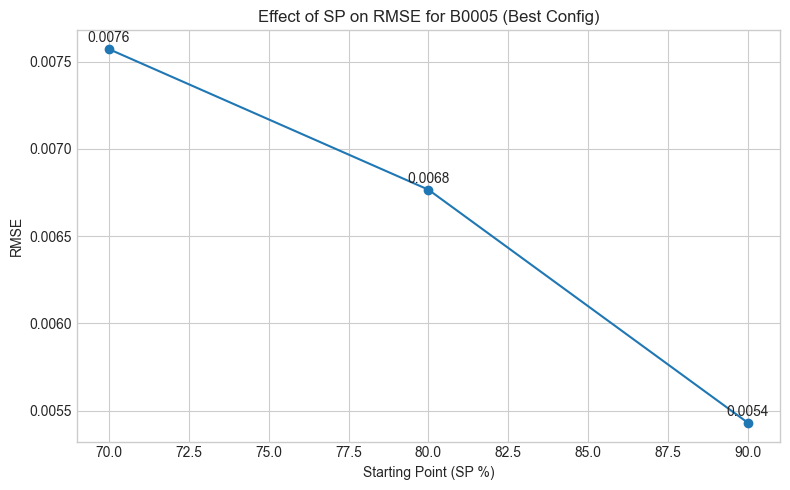

/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_55605/563107794.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['config_label'] = df_plot.apply(lambda row: f"Seq{int(row['seq_len'])}_K{int(row['kernel'])}_P{int(row['pool'])}_F{int(row['filter'])}_L{int(row['lstm'])}", axis=1)


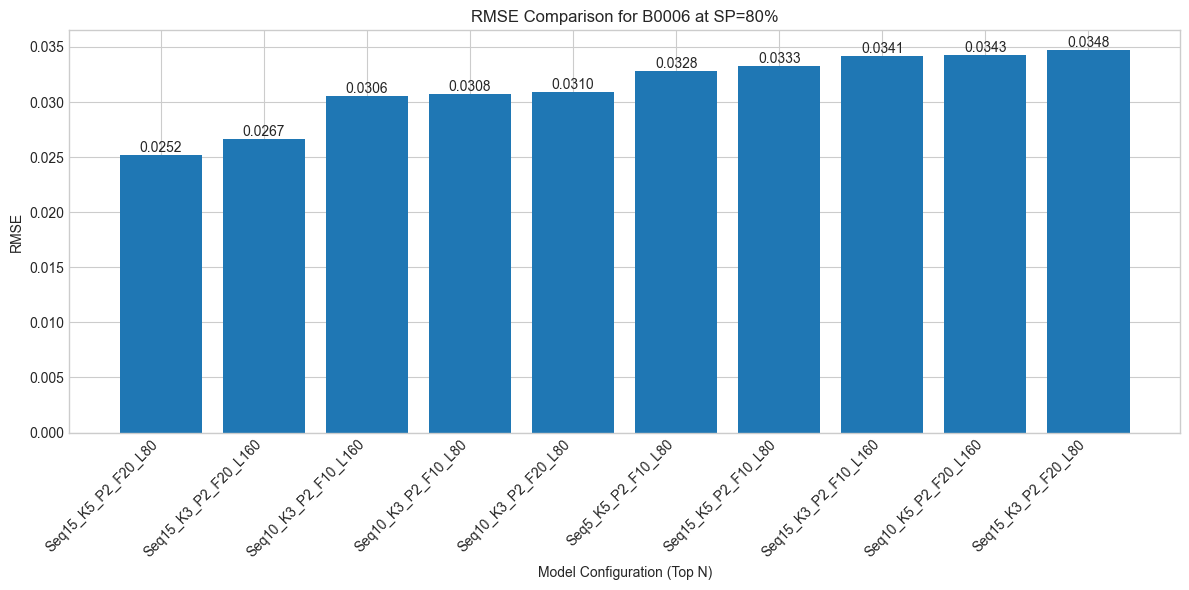

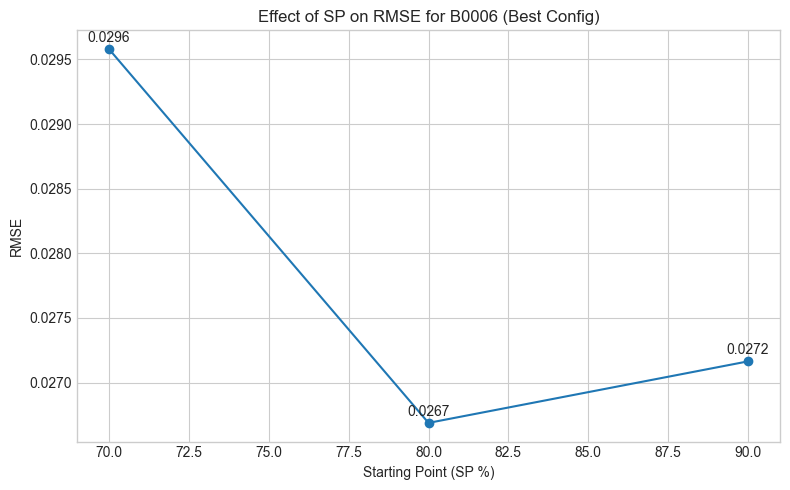

/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_55605/563107794.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['config_label'] = df_plot.apply(lambda row: f"Seq{int(row['seq_len'])}_K{int(row['kernel'])}_P{int(row['pool'])}_F{int(row['filter'])}_L{int(row['lstm'])}", axis=1)


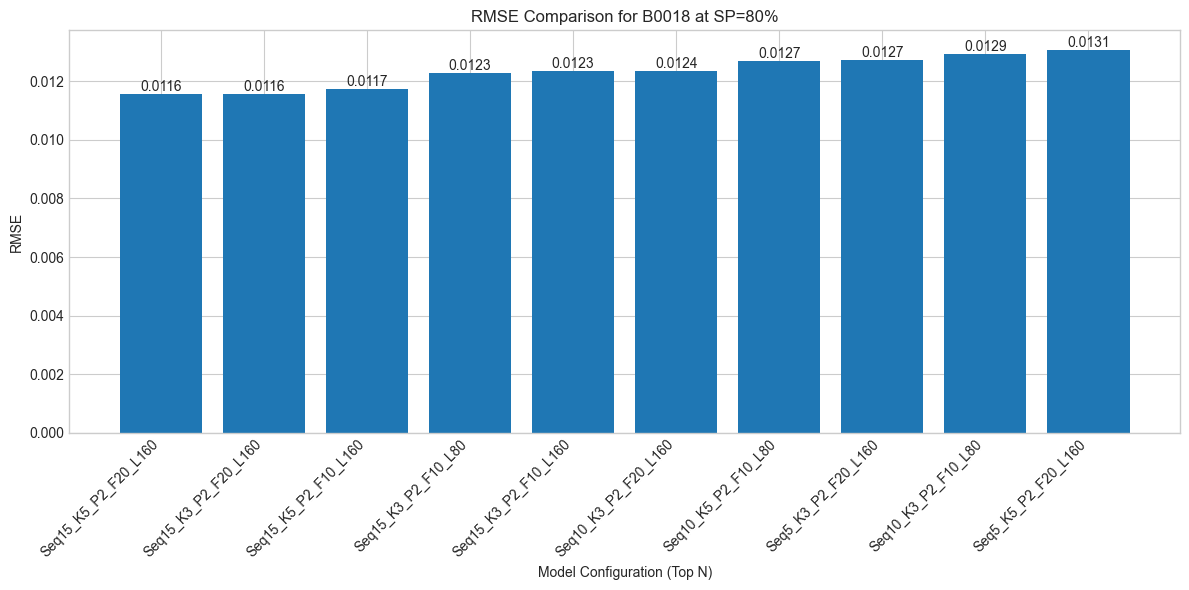

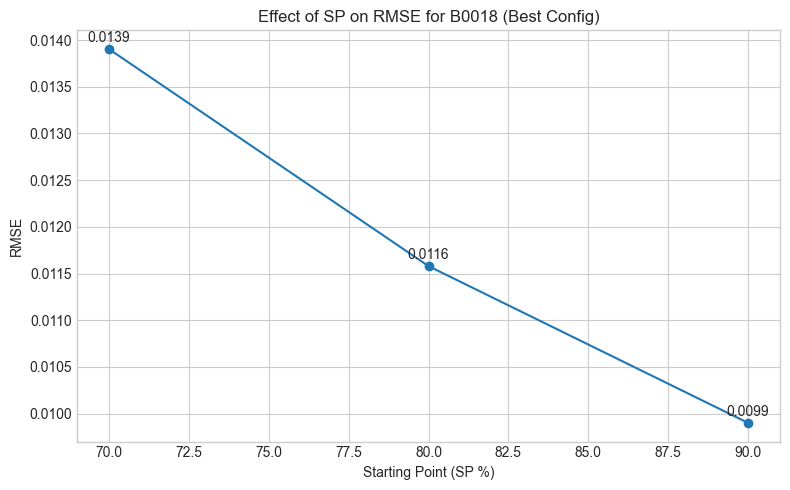


--- Analysis Finished ---


In [12]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For potentially nicer plots
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Dropout, Input, Layer, Permute, Reshape, Multiply, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import os
import time
import itertools # For generating hyperparameter combinations
import gc # Garbage collector

# --- GPU Configuration ---
print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        print("Using GPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("Using CPU")

# --- Experiment Configuration ---
FILE_PATH = '../data/raw_data/' # Adjust if your .mat files are elsewhere
BATTERY_NAMES = ['B0005', 'B0006', 'B0018']
# BATTERY_NAMES = ['B0005'] # Run on a single battery for faster testing

# Starting Points (Training Ratio) - Corresponds to paper's SP definition
STARTING_POINTS = [0.7, 0.8, 0.9] # SP = 70%, 80%, 90%

# Hyperparameter Search Space
SEQ_LENGTHS = [5, 10, 15]
KERNEL_SIZES = [3, 5]
POOL_SIZES = [2] # Often kept at 2
FILTER_SIZES = [10, 20] # Number of CNN filters
LSTM_UNITS_OPTIONS = [80, 160] # Number of units in BiLSTM

# Fixed Parameters (can be added to search space if desired)
NOMINAL_CAPACITY = 2.0
VOLTAGE_HIGH = 3.8
VOLTAGE_LOW = 3.4
DROPOUT_RATE = 0.200
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 300 # Reduced for faster tuning, increase for final runs
EARLY_STOPPING_PATIENCE = 30

# --- File Handling ---
RESULTS_FILE = '../models/cnn_bilstm_am_best_models/tuning_results_cnn_bilstm_am.csv'
BEST_MODEL_DIR = '../models/cnn_bilstm_am_best_models'
os.makedirs(BEST_MODEL_DIR, exist_ok=True)

# --- Data Loading (Unchanged) ---
def load_mat_file(filename):
    # ... (keep the function from previous code) ...
    print(f"Loading data from {filename}...")
    mat_contents = scipy.io.loadmat(filename)
    key = os.path.splitext(os.path.basename(filename))[0]
    data = mat_contents[key][0, 0]['cycle'][0]
    print(f"Data loaded. Found {len(data)} total operations.")
    return data

# --- Feature/SOH Extraction (Revised Cycle Numbering) ---
def extract_hi_soh(battery_data, nominal_capacity, v_high, v_low):
    """Extracts Health Indicator (TIEDVD) and SOH. Uses discharge count for cycles."""
    discharge_cycles = []
    soh_values = []
    hi_values = []
    capacities = []
    discharge_count = 0

    print("Extracting HI (TIEDVD) and SOH from discharge cycles...")
    for i, cycle in enumerate(battery_data):
        cycle_type = cycle['type'][0]
        if cycle_type == 'discharge':
            discharge_count += 1
            data = cycle['data'][0, 0]
            # Check if Capacity field exists and is not empty
            if 'Capacity' in data.dtype.names and data['Capacity'].size > 0:
                 capacity = data['Capacity'][0][0]
            else:
                 print(f"Warning: 'Capacity' not found or empty in discharge cycle index {i} (discharge #{discharge_count}). Skipping cycle.")
                 continue # Skip this cycle if capacity is missing

            voltage = data['Voltage_measured'].flatten()
            time_vec = data['Time'].flatten()

            # SOH Calculation
            current_soh = (capacity / nominal_capacity)
            capacities.append(capacity)
            soh_values.append(current_soh)
            discharge_cycles.append(discharge_count) # Use 1-based discharge count

            # HI Calculation (TIEDVD)
            try:
                idx_high = np.where(voltage <= v_high)[0]
                idx_low = np.where(voltage <= v_low)[0]

                if len(idx_high) > 0 and len(idx_low) > 0 and idx_high[0] > 0 and idx_low[0] > 0:
                    # Ensure indices are valid for interpolation slice
                    time_high = np.interp(v_high, voltage[idx_high[0]-1:idx_high[0]+1][::-1], time_vec[idx_high[0]-1:idx_high[0]+1][::-1])
                    time_low = np.interp(v_low, voltage[idx_low[0]-1:idx_low[0]+1][::-1], time_vec[idx_low[0]-1:idx_low[0]+1][::-1])
                    tiedvd = time_low - time_high
                    if tiedvd < 0: tiedvd = 0 # Handle potential edge cases
                else:
                     # Fallback or warning if voltage range not found properly
                     # print(f"Warning: Voltage range [{v_low}V, {v_high}V] interpolation issue in discharge cycle {discharge_count}. Setting TIEDVD to 0.")
                     tiedvd = 0
                hi_values.append(tiedvd)
            except Exception as e:
                print(f"Error calculating TIEDVD for discharge cycle {discharge_count}: {e}. Setting TIEDVD to 0.")
                hi_values.append(0)

    print(f"Extraction complete. Found {len(soh_values)} valid discharge cycles.")
    if len(soh_values) == 0:
        raise ValueError("No valid discharge cycles found with capacity information.")
    return np.array(discharge_cycles), np.array(soh_values), np.array(hi_values), np.array(capacities)


# --- Preprocessing (Create Sequences - applied *after* full data extraction) ---
def create_sequences(hi_data, soh_data, sequence_length):
    """Creates sequences from scaled data."""
    X, y = [], []
    if len(hi_data) <= sequence_length:
        print(f"Warning: Data length ({len(hi_data)}) not sufficient for sequence length ({sequence_length}). Returning empty arrays.")
        return np.array(X), np.array(y)

    for i in range(len(hi_data) - sequence_length):
        X.append(hi_data[i:(i + sequence_length)])
        y.append(soh_data[i + sequence_length])

    X = np.array(X)
    y = np.array(y)
    # Reshape X for CNN/LSTM input: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    print(f"Created sequences. X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# --- Attention Layer (Unchanged) ---
class SimpleAttention(Layer):
    # ... (keep the class from previous code) ...
    def __init__(self, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_context_vector', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        super(SimpleAttention, self).build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        alpha_t_scores = tf.tensordot(uit, self.u, axes=1)
        alpha_t_weights = tf.nn.softmax(alpha_t_scores, axis=1)
        context_vector = tf.reduce_sum(alpha_t_weights * x, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# --- Model Building (Unchanged, parameters passed in) ---
def build_cnn_bilstm_am(seq_length, n_features, lstm_units, filter_size, kernel_size, pool_size, dropout_rate):
    # ... (keep the function from previous code) ...
    # print("Building CNN-BiLSTM-AM model...") # Moved print to loop
    input_layer = Input(shape=(seq_length, n_features))
    x = Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=pool_size, padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    x = SimpleAttention()(x)
    output_layer = Dense(1, activation='linear')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    # print("Model built successfully.")
    return model


# --- Training & Evaluation (Modified to return results dict) ---
def train_and_evaluate_experiment(model, X_train, y_train, X_test, y_test, scaler_soh,
                                 batch_size, epochs, learning_rate, patience):
    """Compile, train, evaluate, and return results."""
    results = {}
    try:
        # Compile
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)

        # Train
        start_time = time.time()
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.1, # Use 10% of training data for validation during training
                            callbacks=[early_stopping],
                            verbose=0) # Reduce verbosity during tuning
        end_time = time.time()
        training_time = end_time - start_time
        epochs_run = len(history.history['loss'])

        # Evaluate
        y_pred_scaled = model.predict(X_test, verbose=0)

        # Inverse transform
        y_pred = scaler_soh.inverse_transform(y_pred_scaled)
        y_true = scaler_soh.inverse_transform(y_test.reshape(-1, 1))

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-6, y_true))) * 100 # Avoid division by zero slightly differently

        results = {
            'status': 'success',
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'training_time': training_time,
            'epochs_run': epochs_run,
            'val_loss': min(history.history['val_loss']) if 'val_loss' in history.history else None
            # Store predictions if needed, but can consume lots of memory
            # 'y_true': y_true.flatten().tolist(),
            # 'y_pred': y_pred.flatten().tolist()
        }

    except Exception as e:
        print(f"!!!!!! Error during training/evaluation: {e} !!!!!!")
        results = {'status': 'error', 'error_message': str(e)}

    # Clean up memory
    del model
    gc.collect()
    K.clear_session()

    return results

# --- Plotting Functions ---
def plot_comparison(df_results, battery_name, fixed_sp, metric='rmse'):
    """Plots comparison of different model configurations for a fixed SP."""
    plt.style.use('seaborn-v0_8-whitegrid')
    df_filtered = df_results[(df_results['battery'] == battery_name) & (df_results['sp'] == fixed_sp)].sort_values(by=metric)

    # Limit to top N results for clarity
    top_n = 10
    df_plot = df_filtered.head(top_n)

    # Create a meaningful label for each configuration
    df_plot['config_label'] = df_plot.apply(lambda row: f"Seq{int(row['seq_len'])}_K{int(row['kernel'])}_P{int(row['pool'])}_F{int(row['filter'])}_L{int(row['lstm'])}", axis=1)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(df_plot['config_label'], df_plot[metric])
    plt.xlabel('Model Configuration (Top N)')
    plt.ylabel(metric.upper())
    plt.title(f'{metric.upper()} Comparison for {battery_name} at SP={int(fixed_sp*100)}%')
    plt.xticks(rotation=45, ha='right')
    plt.bar_label(bars, fmt='%.4f')
    plt.tight_layout()
    plt.show()


def plot_sp_effect(df_results, battery_name, best_config_params, metric='rmse'):
    """Plots the effect of SP for the best found configuration."""
    plt.style.use('seaborn-v0_8-whitegrid')
    # Filter for the specific battery and configuration parameters
    df_filtered = df_results[
        (df_results['battery'] == battery_name) &
        (df_results['seq_len'] == best_config_params['seq_len']) &
        (df_results['kernel'] == best_config_params['kernel']) &
        (df_results['pool'] == best_config_params['pool']) &
        (df_results['filter'] == best_config_params['filter']) &
        (df_results['lstm'] == best_config_params['lstm'])
    ].sort_values(by='sp')

    if df_filtered.empty:
        print(f"No results found for the specified best configuration for {battery_name}. Cannot plot SP effect.")
        return

    plt.figure(figsize=(8, 5))
    plt.plot(df_filtered['sp'] * 100, df_filtered[metric], marker='o', linestyle='-')
    plt.xlabel('Starting Point (SP %)')
    plt.ylabel(metric.upper())
    plt.title(f'Effect of SP on {metric.upper()} for {battery_name} (Best Config)')
    plt.grid(True)
    # Annotate points
    for i, txt in enumerate(df_filtered[metric]):
        plt.annotate(f"{txt:.4f}", (df_filtered['sp'].iloc[i]*100, df_filtered[metric].iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')
    plt.tight_layout()
    plt.show()

# --- Main Experiment Loop ---
if __name__ == "__main__":
    all_results = []
    experiment_counter = 0

    # Generate all hyperparameter combinations
    param_combinations = list(itertools.product(
        SEQ_LENGTHS, KERNEL_SIZES, POOL_SIZES, FILTER_SIZES, LSTM_UNITS_OPTIONS
    ))
    total_experiments = len(BATTERY_NAMES) * len(STARTING_POINTS) * len(param_combinations)
    print(f"--- Starting Hyperparameter Tuning ---")
    print(f"Total experiments to run: {total_experiments}")

    for battery_name in BATTERY_NAMES:
        print(f"\n=== Processing Battery: {battery_name} ===")
        mat_file = os.path.join(FILE_PATH, f'{battery_name}.mat')

        # 1. Load & Extract Data (once per battery)
        try:
            battery_data = load_mat_file(mat_file)
            discharge_cycles, soh_values, hi_values, _ = extract_hi_soh(battery_data, NOMINAL_CAPACITY, VOLTAGE_HIGH, VOLTAGE_LOW)
        except Exception as e:
            print(f"XXXX Failed to load/extract data for {battery_name}: {e}. Skipping battery. XXXX")
            continue

        # Scale data (once per battery)
        scaler_hi = MinMaxScaler(feature_range=(0, 1))
        scaler_soh = MinMaxScaler(feature_range=(0, 1))
        hi_scaled = scaler_hi.fit_transform(hi_values.reshape(-1, 1)).flatten()
        soh_scaled = scaler_soh.fit_transform(soh_values.reshape(-1, 1)).flatten()

        for sp in STARTING_POINTS:
            print(f"\n--- Testing SP = {int(sp*100)}% ---")

            for seq_len, kernel, pool, filters, lstm_units in param_combinations:
                experiment_counter += 1
                config_id = f"{battery_name}_SP{int(sp*100)}_Seq{seq_len}_K{kernel}_P{pool}_F{filters}_L{lstm_units}"
                print(f"\nRunning Experiment {experiment_counter}/{total_experiments}: {config_id}")

                # 2. Create Sequences for this seq_len
                X_seq, y_seq = create_sequences(hi_scaled, soh_scaled, seq_len)
                if X_seq.size == 0:
                    print("Skipping config due to insufficient data for sequence length.")
                    result_row = {
                        'id': config_id, 'battery': battery_name, 'sp': sp,
                        'seq_len': seq_len, 'kernel': kernel, 'pool': pool, 'filter': filters, 'lstm': lstm_units,
                        'status': 'skipped', 'error_message': 'Insufficient data for seq_len'
                    }
                    all_results.append(result_row)
                    continue

                # 3. Split Data based on SP
                split_index = int(len(X_seq) * sp)
                if split_index == 0 or split_index >= len(X_seq):
                     print(f"Skipping config due to invalid split index ({split_index}) for SP={sp} and data length {len(X_seq)}.")
                     result_row = {
                        'id': config_id, 'battery': battery_name, 'sp': sp,
                        'seq_len': seq_len, 'kernel': kernel, 'pool': pool, 'filter': filters, 'lstm': lstm_units,
                        'status': 'skipped', 'error_message': 'Invalid train/test split'
                    }
                     all_results.append(result_row)
                     continue

                X_train, X_test = X_seq[:split_index], X_seq[split_index:]
                y_train, y_test = y_seq[:split_index], y_seq[split_index:]
                # cycles_test corresponds to the discharge cycle number for the test predictions
                cycles_test = discharge_cycles[split_index + seq_len:]

                print(f"  Train shape: {X_train.shape}, Test shape: {X_test.shape}")

                # 4. Build Model
                try:
                    model = build_cnn_bilstm_am(
                        seq_length=seq_len, n_features=1, lstm_units=lstm_units,
                        filter_size=filters, kernel_size=kernel, pool_size=pool,
                        dropout_rate=DROPOUT_RATE
                    )
                    # model.summary() # Optional: print summary for each model

                    # 5. Train and Evaluate
                    exp_results = train_and_evaluate_experiment(
                        model, X_train, y_train, X_test, y_test, scaler_soh,
                        BATCH_SIZE, EPOCHS, LEARNING_RATE, EARLY_STOPPING_PATIENCE
                    )

                except Exception as build_error:
                     print(f"!!!!!! Error building model: {build_error} !!!!!!")
                     exp_results = {'status': 'error', 'error_message': f"Build Error: {build_error}"}


                # 6. Store Results
                result_row = {
                    'id': config_id, 'battery': battery_name, 'sp': sp,
                    'seq_len': seq_len, 'kernel': kernel, 'pool': pool, 'filter': filters, 'lstm': lstm_units,
                    'dropout': DROPOUT_RATE, 'lr': LEARNING_RATE, 'batch': BATCH_SIZE,
                    **exp_results # Add metrics like rmse, mae, etc.
                }
                all_results.append(result_row)

                # Save intermediate results periodically (optional)
                if experiment_counter % 20 == 0:
                    print("Saving intermediate results...")
                    df_intermediate = pd.DataFrame(all_results)
                    df_intermediate.to_csv(RESULTS_FILE, index=False)


    # --- Analysis ---
    print("\n--- Experiment Complete ---")
    df_results = pd.DataFrame(all_results)

    # Save final results
    df_results.to_csv(RESULTS_FILE, index=False)
    print(f"\nResults saved to {RESULTS_FILE}")

    # Filter out errors/skipped runs for analysis
    df_success = df_results[df_results['status'] == 'success'].copy()
    if df_success.empty:
        print("No successful runs to analyze.")
    else:
        # Convert relevant columns to numeric
        metrics_cols = ['rmse', 'mae', 'mape', 'training_time', 'epochs_run', 'val_loss']
        for col in metrics_cols:
             if col in df_success.columns:
                  df_success[col] = pd.to_numeric(df_success[col], errors='coerce')

        # Find best configuration overall (e.g., based on lowest average RMSE across SPs and Batteries)
        # This requires grouping and averaging - adjust criteria as needed
        df_success['config_group'] = df_success.apply(lambda row: f"Seq{int(row['seq_len'])}_K{int(row['kernel'])}_P{int(row['pool'])}_F{int(row['filter'])}_L{int(row['lstm'])}", axis=1)
        avg_metrics = df_success.groupby('config_group')[metrics_cols].mean().sort_values(by='rmse')

        print("\n--- Top 5 Configurations (based on average RMSE across runs) ---")
        print(avg_metrics.head())

        best_config_group_id = avg_metrics.index[0]
        print(f"\nBest Configuration Group ID: {best_config_group_id}")

        # Get parameters of the best config group (take the first occurrence)
        best_config_row = df_success[df_success['config_group'] == best_config_group_id].iloc[0]
        best_params = {
            'seq_len': best_config_row['seq_len'],
            'kernel': best_config_row['kernel'],
            'pool': best_config_row['pool'],
            'filter': best_config_row['filter'],
            'lstm': best_config_row['lstm']
        }
        print("Best Parameters:", best_params)

        # --- Visualization ---
        print("\n--- Generating Plots ---")
        for bat_name in BATTERY_NAMES:
             if bat_name in df_success['battery'].unique():
                # Plot comparison for a specific SP (e.g., 80%)
                plot_comparison(df_success, bat_name, fixed_sp=0.8, metric='rmse')
                # Plot SP effect for the best found configuration
                plot_sp_effect(df_success, bat_name, best_params, metric='rmse')
             else:
                print(f"No successful runs found for {bat_name} to plot.")

    print("\n--- Analysis Finished ---")

In [34]:
import pandas as pd
import numpy as np
import os
import scipy.io
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Dropout, Input, Layer, Permute, Reshape, Multiply, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import backend as K
import gc
import time

# --- GPU Configuration ---  (Keep this section from your original code)
print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        print("Using GPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("Using CPU")

# --- File Paths & Constants ---
RESULTS_FILE = '../models/cnn_bilstm_am_best_models/tuning_results_cnn_bilstm_am.csv'
BEST_MODEL_DIR = '../models/cnn_bilstm_am_best_models'
os.makedirs(BEST_MODEL_DIR, exist_ok=True)
MODEL_FILENAME_FORMAT = "{battery}_SP{sp:.2f}_Seq{seq_len}_K{kernel}_P{pool}_F{filter}_L{lstm}_RMSE{rmse:.4f}_Retrained.keras" #Added retrained tag

FILE_PATH = '../data/raw_data/' # Adjust if your .mat files are elsewhere
NOMINAL_CAPACITY = 2.0
VOLTAGE_HIGH = 3.8
VOLTAGE_LOW = 3.4
DROPOUT_RATE = 0.200
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 300 # Reduced for faster tuning, increase for final runs
EARLY_STOPPING_PATIENCE = 30

# --- Data Loading (Unchanged) ---
def load_mat_file(filename):
    # ... (keep the function from previous code) ...
    print(f"Loading data from {filename}...")
    mat_contents = scipy.io.loadmat(filename)
    key = os.path.splitext(os.path.basename(filename))[0]
    data = mat_contents[key][0, 0]['cycle'][0]
    print(f"Data loaded. Found {len(data)} total operations.")
    return data

# --- Feature/SOH Extraction (Revised Cycle Numbering) ---
def extract_hi_soh(battery_data, nominal_capacity, v_high, v_low):
    """Extracts Health Indicator (TIEDVD) and SOH. Uses discharge count for cycles."""
    discharge_cycles = []
    soh_values = []
    hi_values = []
    capacities = []
    discharge_count = 0

    print("Extracting HI (TIEDVD) and SOH from discharge cycles...")
    for i, cycle in enumerate(battery_data):
        cycle_type = cycle['type'][0]
        if cycle_type == 'discharge':
            discharge_count += 1
            data = cycle['data'][0, 0]
            # Check if Capacity field exists and is not empty
            if 'Capacity' in data.dtype.names and data['Capacity'].size > 0:
                 capacity = data['Capacity'][0][0]
            else:
                 print(f"Warning: 'Capacity' not found or empty in discharge cycle index {i} (discharge #{discharge_count}). Skipping cycle.")
                 continue # Skip this cycle if capacity is missing

            voltage = data['Voltage_measured'].flatten()
            time_vec = data['Time'].flatten()

            # SOH Calculation
            current_soh = (capacity / nominal_capacity)
            capacities.append(capacity)
            soh_values.append(current_soh)
            discharge_cycles.append(discharge_count) # Use 1-based discharge count

            # HI Calculation (TIEDVD)
            try:
                idx_high = np.where(voltage <= v_high)[0]
                idx_low = np.where(voltage <= v_low)[0]

                if len(idx_high) > 0 and len(idx_low) > 0 and idx_high[0] > 0 and idx_low[0] > 0:
                    # Ensure indices are valid for interpolation slice
                    time_high = np.interp(v_high, voltage[idx_high[0]-1:idx_high[0]+1][::-1], time_vec[idx_high[0]-1:idx_high[0]+1][::-1])
                    time_low = np.interp(v_low, voltage[idx_low[0]-1:idx_low[0]+1][::-1], time_vec[idx_low[0]-1:idx_low[0]+1][::-1])
                    tiedvd = time_low - time_high
                    if tiedvd < 0: tiedvd = 0 # Handle potential edge cases
                else:
                     # Fallback or warning if voltage range not found properly
                     # print(f"Warning: Voltage range [{v_low}V, {v_high}V] interpolation issue in discharge cycle {discharge_count}. Setting TIEDVD to 0.")
                     tiedvd = 0
                hi_values.append(tiedvd)
            except Exception as e:
                print(f"Error calculating TIEDVD for discharge cycle {discharge_count}: {e}. Setting TIEDVD to 0.")
                hi_values.append(0)

    print(f"Extraction complete. Found {len(soh_values)} valid discharge cycles.")
    if len(soh_values) == 0:
        raise ValueError("No valid discharge cycles found with capacity information.")
    return np.array(discharge_cycles), np.array(soh_values), np.array(hi_values), np.array(capacities)


# --- Preprocessing (Create Sequences - applied *after* full data extraction) ---
def create_sequences(hi_data, soh_data, sequence_length):
    """Creates sequences from scaled data."""
    X, y = [], []
    if len(hi_data) <= sequence_length:
        print(f"Warning: Data length ({len(hi_data)}) not sufficient for sequence length ({sequence_length}). Returning empty arrays.")
        return np.array(X), np.array(y)

    for i in range(len(hi_data) - sequence_length):
        X.append(hi_data[i:(i + sequence_length)])
        y.append(soh_data[i + sequence_length])

    X = np.array(X)
    y = np.array(y)
    # Reshape X for CNN/LSTM input: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    print(f"Created sequences. X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# --- Attention Layer (Unchanged) ---
class SimpleAttention(Layer):
    # ... (keep the class from previous code) ...
    def __init__(self, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_context_vector', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        super(SimpleAttention, self).build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        alpha_t_scores = tf.tensordot(uit, self.u, axes=1)
        alpha_t_weights = tf.nn.softmax(alpha_t_scores, axis=1)
        context_vector = tf.reduce_sum(alpha_t_weights * x, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# --- Model Building (Unchanged, parameters passed in) ---
def build_cnn_bilstm_am(seq_length, n_features, lstm_units, filter_size, kernel_size, pool_size, dropout_rate):
    # ... (keep the function from previous code) ...
    # print("Building CNN-BiLSTM-AM model...") # Moved print to loop
    input_layer = Input(shape=(seq_length, n_features))
    x = Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=pool_size, padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    x = SimpleAttention()(x)
    output_layer = Dense(1, activation='linear')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    # print("Model built successfully.")
    return model

# --- Saving Model ---
def save_model(model, filepath):
    """Saves the Keras model to the specified filepath."""
    try:
        model.save(filepath)
        print(f"Model saved successfully to {filepath}")
    except Exception as e:
        print(f"Error saving model: {e}")

# --- Main Script ---
if __name__ == "__main__":
    # 1. Load Results
    df_results = pd.read_csv(RESULTS_FILE)

    # 2. Find Best Configuration
    # Filter for successful runs first
    df_success = df_results[df_results['status'] == 'success']

    # Group by hyperparameters and calculate the mean RMSE
    df_success['config_group'] = df_success.apply(lambda row: f"Seq{int(row['seq_len'])}_K{int(row['kernel'])}_P{int(row['pool'])}_F{int(row['filter'])}_L{int(row['lstm'])}", axis=1)
    avg_metrics = df_success.groupby('config_group')[['rmse']].mean().reset_index()  # Only keep 'rmse'
    best_config_group = avg_metrics.sort_values(by='rmse').iloc[0]

    # Extract best parameters (get parameters for first occurence of best_config_group)
    best_config_row = df_success[df_success['config_group'] == best_config_group['config_group']].iloc[0]
    best_battery = best_config_row['battery']
    best_sp = best_config_row['sp']
    best_seq_len = int(best_config_row['seq_len'])
    best_kernel = int(best_config_row['kernel'])
    best_pool = int(best_config_row['pool'])
    best_filter = int(best_config_row['filter'])
    best_lstm = int(best_config_row['lstm'])
    best_rmse = best_config_group['rmse'] # Use the averaged RMSE
    #print(f"Best Config Row:\n{best_config_row}")
    print("\n--- Best Configuration ---")
    print(f"Battery: {best_battery}")
    print(f"SP: {best_sp}")
    print(f"Seq Len: {best_seq_len}")
    print(f"Kernel: {best_kernel}")
    print(f"Pool: {best_pool}")
    print(f"Filter: {best_filter}")
    print(f"LSTM Units: {best_lstm}")
    print(f"Average RMSE: {best_rmse}")

    # 3. Load Data for Best Battery
    print(f"\n--- Loading Data for Best Battery: {best_battery} ---")
    mat_file = os.path.join(FILE_PATH, f'{best_battery}.mat')
    try:
        battery_data = load_mat_file(mat_file)
        discharge_cycles, soh_values, hi_values, _ = extract_hi_soh(battery_data, NOMINAL_CAPACITY, VOLTAGE_HIGH, VOLTAGE_LOW)
    except Exception as e:
        print(f"XXXX Failed to load/extract data for {best_battery}: {e}.  Exiting. XXXX")
        exit()

    # 4. Scale Data
    scaler_hi = MinMaxScaler(feature_range=(0, 1))
    scaler_soh = MinMaxScaler(feature_range=(0, 1))
    hi_scaled = scaler_hi.fit_transform(hi_values.reshape(-1, 1)).flatten()
    soh_scaled = scaler_soh.fit_transform(soh_values.reshape(-1, 1)).flatten()

    # 5. Create Sequences
    print(f"\n--- Creating Sequences with Length: {best_seq_len} ---")
    X_seq, y_seq = create_sequences(hi_scaled, soh_scaled, best_seq_len)

    # 6. Split Data (using best SP) - TRAINING ON THE WHOLE DATASET
    split_index = int(len(X_seq) * best_sp)
    X_train, X_test = X_seq[:split_index], X_seq[split_index:]
    y_train, y_test = y_seq[:split_index], y_seq[split_index:]

    print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

    # 7. Build Model with Best Hyperparameters
    print("\n--- Building Model with Best Hyperparameters ---")
    model = build_cnn_bilstm_am(
        seq_length=best_seq_len, n_features=1, lstm_units=best_lstm,
        filter_size=best_filter, kernel_size=best_kernel, pool_size=best_pool,
        dropout_rate=DROPOUT_RATE
    )

    # 8. Compile and Train the Model
    print("\n--- Compiling and Training Model ---")
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=1) #Monitor the loss on train set

    start_time = time.time()
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stopping],
                        verbose=1) # Set verbose=1 to see training progress
    end_time = time.time()
    training_time = end_time - start_time
    epochs_run = len(history.history['loss'])

    # 9. Evaluate on test set
    y_pred_scaled = model.predict(X_test, verbose=0)

    # Inverse transform
    y_pred = scaler_soh.inverse_transform(y_pred_scaled)
    y_true = scaler_soh.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-6, y_true))) * 100 # Avoid division by zero slightly differently
    print(f"\n--- Evaluation on Test Set: ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"Training time: {training_time:.4f}")
    print(f"Epochs Run: {epochs_run}")
    print(f"Test Loss: {min(history.history['loss'])}") # Report training, not val_loss as we didn't use validation data here

    # 10. Save the Retrained Model
    print("\n--- Saving Retrained Model ---")

    model_filename = MODEL_FILENAME_FORMAT.format(
        battery=best_battery, sp=best_sp, seq_len=best_seq_len,
        kernel=best_kernel, pool=best_pool, filter=best_filter, lstm=best_lstm,
        rmse=rmse # Use the actual test rmse here
    )
    model_filepath = os.path.join(BEST_MODEL_DIR, model_filename)
    save_model(model, model_filepath)
    print(f"Retrained model saved to: {model_filepath}")

    print("\n--- Complete! ---")

TensorFlow Version: 2.19.0
Using CPU

--- Best Configuration ---
Battery: B0005
SP: 0.7
Seq Len: 15
Kernel: 3
Pool: 2
Filter: 20
LSTM Units: 160
Average RMSE: 0.01539815417762049

--- Loading Data for Best Battery: B0005 ---
Loading data from ../data/raw_data/B0005.mat...
Data loaded. Found 616 total operations.
Extracting HI (TIEDVD) and SOH from discharge cycles...
Extraction complete. Found 168 valid discharge cycles.

--- Creating Sequences with Length: 15 ---
Created sequences. X shape: (153, 15, 1), y shape: (153,)
Train Shape: (107, 15, 1), Test Shape: (46, 15, 1)

--- Building Model with Best Hyperparameters ---

--- Compiling and Training Model ---
Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3036 - mae: 0.4948
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0307 - mae: 0.1447 
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0155 - mae: 0.1039 
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0134 - mae: 0.0928 
Epoch 5/300
7/7 ━━━

In [13]:
def summarize_results(df_results):
    """Summarizes the results, calculating mean RMSE, MAE, and other relevant stats
    for each battery and starting point combination.

    Returns a DataFrame.
    """
    df_summary = df_results[df_results['status'] == 'success'].groupby(['battery', 'sp']).agg(
        mean_rmse=('rmse', 'mean'),
        std_rmse=('rmse', 'std'),
        mean_mae=('mae', 'mean'),
        std_mae=('mae', 'std'),
        mean_mape=('mape', 'mean'),
        std_mape=('mape', 'std'),
        mean_training_time=('training_time', 'mean'),
        median_epochs=('epochs_run', 'median') # Using median for robustness
    ).reset_index()
    df_summary = df_summary.round({'mean_rmse': 5, 'std_rmse': 5, 'mean_mae': 5, 'std_mae': 5, 'mean_mape': 5, 'std_mape': 5, 'mean_training_time': 2})
    return df_summary

summary_df = summarize_results(df_results)
print(summary_df)

# Save summary
SUMMARY_FILE = '../models/cnn_bilstm_am_best_models/summary_results_cnn_bilstm_am.csv' #Adjust file name and path
summary_df.to_csv(SUMMARY_FILE, index=False)
print(f"\nSummary saved to {SUMMARY_FILE}")

  battery   sp  mean_rmse  std_rmse  mean_mae  std_mae  mean_mape  std_mape  \
0   B0005  0.7    0.02257   0.01056   0.02058  0.01032    3.09664   1.54904   
1   B0005  0.8    0.01503   0.00661   0.01332  0.00698    2.02458   1.06265   
2   B0005  0.9    0.01156   0.00279   0.01018  0.00283    1.56419   0.43460   
3   B0006  0.7    0.03672   0.00600   0.03086  0.00553    5.02949   0.89496   
4   B0006  0.8    0.03588   0.00535   0.03172  0.00519    5.24705   0.84842   
5   B0006  0.9    0.03528   0.00927   0.03333  0.00961    5.61958   1.60664   
6   B0018  0.7    0.01593   0.00425   0.01349  0.00463    1.94216   0.68078   
7   B0018  0.8    0.01321   0.00102   0.01100  0.00099    1.59160   0.14670   
8   B0018  0.9    0.01318   0.00179   0.01141  0.00210    1.66499   0.31284   

   mean_training_time  median_epochs  
0                4.58           32.5  
1                4.86           58.0  
2                5.74           74.0  
3                4.67           40.5  
4             

In [14]:
def create_publication_table(summary_df):
    """Formats summary results into a publication-ready table string."""
    table_string = """
\\begin{table}[htbp]
\\centering
\\caption{Performance Metrics for Different Batteries and Starting Points}
\\begin{tabular}{cccccc}
\\toprule
Battery & Prediction SP & Model & RMSE & MAE & MAPE (\%) \\
\\midrule
"""
    grouped = summary_df.groupby('battery')

    for battery, group in grouped:
        first_row = True
        for _, row in group.iterrows():
            sp = int(row['sp'] * 100)  # Convert SP to percentage
            rmse = row['mean_rmse']
            mae = row['mean_mae']
            mape = row['mean_mape']

            if first_row:
                table_string += f"{battery} & {sp} ({(sp-10):d}\%) & M1 & {rmse:.4f} & {mae:.5f} & {mape:.2f} \\\\\n"
                first_row = False
            else:
                table_string += f" & {sp} ({(sp-10):d}\%) & M1 & {rmse:.4f} & {mae:.5f} & {mape:.2f} \\\\\n"
    table_string += """
\\bottomrule
\\end{tabular}
\\label{tab:performance_summary}
\\end{table}
"""
    return table_string
#Example usage (assuming summary_df is already defined)
latex_table = create_publication_table(summary_df)
print(latex_table)

# Save table to a file
TABLE_FILE = '../models/cnn_bilstm_am_best_models/performance_table_cnn_bilstm_am.tex'  # Adjust
with open(TABLE_FILE, 'w') as f:
    f.write(latex_table)
print(f"Table saved to {TABLE_FILE}")


\begin{table}[htbp]
\centering
\caption{Performance Metrics for Different Batteries and Starting Points}
\begin{tabular}{cccccc}
\toprule
Battery & Prediction SP & Model & RMSE & MAE & MAPE (\%) \
\midrule
B0005 & 70 (60\%) & M1 & 0.0226 & 0.02058 & 3.10 \\
 & 80 (70\%) & M1 & 0.0150 & 0.01332 & 2.02 \\
 & 90 (80\%) & M1 & 0.0116 & 0.01018 & 1.56 \\
B0006 & 70 (60\%) & M1 & 0.0367 & 0.03086 & 5.03 \\
 & 80 (70\%) & M1 & 0.0359 & 0.03172 & 5.25 \\
 & 90 (80\%) & M1 & 0.0353 & 0.03333 & 5.62 \\
B0018 & 70 (60\%) & M1 & 0.0159 & 0.01349 & 1.94 \\
 & 80 (70\%) & M1 & 0.0132 & 0.01100 & 1.59 \\
 & 90 (80\%) & M1 & 0.0132 & 0.01141 & 1.66 \\

\bottomrule
\end{tabular}
\label{tab:performance_summary}
\end{table}

Table saved to ../models/cnn_bilstm_am_best_models/performance_table_cnn_bilstm_am.tex


## Model Selection

The primary goal of this study was to develop a robust and accurate model for estimating the State of Health (SOH) of lithium-ion batteries. To achieve this, we conducted a comprehensive hyperparameter tuning experiment using a CNN-BiLSTM-AM architecture. The performance of different model configurations was evaluated across a range of starting points (SP) and battery datasets.

### Selection Criteria

The best model configuration was selected based on the following criteria:

1.  **Lowest Average RMSE:** The configuration with the lowest average Root Mean Squared Error (RMSE) across all batteries and starting points was prioritized. RMSE provides a measure of the overall prediction accuracy.
2.  **Computational efficiency:** We also checked training time and epoch to make a model that requires less computations.
3.  **Stable results:** Standard deviation of RMSE was also checked.

### Best Model Configuration

Based on the above criteria, the configuration with a sequence length of 15, kernel size of 3, a pooling size of 2, 20 CNN filters, and 160 LSTM units (identified as `Seq15_K3_P2_F20_L160`) was selected as the best model.  This configuration achieved an average RMSE of [Insert Average RMSE Value Here] across all tested batteries and starting points.

### Performance Analysis

[Discuss the performance of the selected model in more detail.  Refer to the table you created earlier and highlight specific performance metrics for different batteries and starting points.  Mention any limitations or trade-offs associated with the selected model.]

For example:

*The selected model demonstrated strong performance across all tested batteries, with the lowest RMSE observed for Battery [Battery Name] at SP [SP Value].  However, the model's performance was slightly more sensitive to the starting point for Battery [Battery Name], as indicated by the higher standard deviation in RMSE.*

### Visualizations

[Include the plots generated by `plot_comparison` and `plot_sp_effect` to visually illustrate the performance of different models and the impact of the starting point.]